In [66]:
## Parameters ##
#==============#

# Centroids of home and work locations in lat/lonE7
home = (-739570500, 406310500)
work = (-740023790, 407157170)

# Size of buffer around home/work centroids
buffer = 30000


# Optional parameters to further improve the results.  
# ===================================================
# Days that you work 0 = Monday, 6 = Sunday
workdays = [0, 1, 2, 3, 4]

# Time period commuting between this pair of home/work locations
timeframe = ['2016-09-12', '2018-01-01']

# Possible commute times in minutes for your commute.  
# For instance, if you know the commute should never be less than 20 minutes
# or greater than 3 hours, then use range [20, 180]
possible_commute_times = [20, 180]

# Time range when you depart for work in hours.
# For example, leaving for work between 7:00 and 9:00
departure_timeframe = [datetime.time(7), datetime.time(9)]

In [1]:
%matplotlib inline

In [34]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gp
import json
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [4]:
buffer = 30000

locations = gp.GeoDataFrame({
    'location': ['home', 'work'], 
    'geometry': [Point(home).buffer(buffer), Point(work).buffer(buffer)]
})

locations.crs = {'init' :'epsg:4326'}
locations

,geometry,location
0,"POLYGON ((-739540500 406310500, -739540644.458...",home
1,"POLYGON ((-739993790 407157170, -739993934.458...",work


In [62]:
with open('Location History.json') as data_file:    
    data = json.load(data_file)
    
df = pd.DataFrame.from_records(data['locations'])
df['timestampMs'] = df['timestampMs'].astype('int64')
df['timestamp'] = pd.to_datetime(df['timestampMs'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
df['geometry'] = df.apply(lambda r: Point(r['longitudeE7'], r['latitudeE7']), axis=1)

df['date'] = df['timestamp'].dt.date
df['weekday'] = df['timestamp'].dt.weekday

gdf = gp.GeoDataFrame(df[
    (df['weekday'].isin(workdays)) & 
    (df['timestamp'].between(pd.to_datetime(timeframe[0]), pd.to_datetime(timeframe[1])))
])
gdf.crs = {'init' :'epsg:4326'}

In [64]:
joined = gp.sjoin(locations, gdf, op='contains').reset_index().sort_values('timestamp')

joined['location_i'] = 0
joined.loc[joined['location'] == 'work', 'location_i'] = 1
joined['diff'] = joined['location_i'].diff()
joined['timediff'] = joined['timestamp'].diff()


joined

,index,geometry,location,index_right,accuracy,activity,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy,timestamp,date,weekday,location_i,diff,timediff
101550,0,"POLYGON ((-739540500 406310500, -739540644.458...",home,489527,9,NaN,-7.0,NaN,406309679,-739583428,1473652811000,0.0,NaN,2016-09-12 00:00:11-04:00,2016-09-12,0,0,NaN,NaT
101549,0,"POLYGON ((-739540500 406310500, -739540644.458...",home,489526,4,NaN,-7.0,NaN,406309678,-739583426,1473652826000,0.0,NaN,2016-09-12 00:00:26-04:00,2016-09-12,0,0,0.0,00:00:15
101548,0,"POLYGON ((-739540500 406310500, -739540644.458...",home,489525,4,NaN,-7.0,NaN,406309677,-739583424,1473652844000,0.0,NaN,2016-09-12 00:00:44-04:00,2016-09-12,0,0,0.0,00:00:18
101547,0,"POLYGON ((-739540500 406310500, -739540644.458...",home,489524,4,NaN,-7.0,NaN,406309676,-739583424,1473652859000,0.0,NaN,2016-09-12 00:00:59-04:00,2016-09-12,0,0,0.0,00:00:15
101546,0,"POLYGON ((-739540500 406310500, -739540644.458...",home,489523,8,NaN,-7.0,NaN,406309674,-739583423,1473652874000,0.0,NaN,2016-09-12 00:01:14-04:00,2016-09-12,0,0,0.0,00:00:15
101545,0,"POLYGON ((-739540500 406310500, -739540644.458...",home,489522,6,NaN,-7.0,NaN,406309674,-739583422,1473652892000,0.0,NaN,2016-09-12 00:01:32-04:00,2016-09-12,0,0,0.0,00:00:18
101544,0,"POLYGON ((-739540500 406310500, -739540644.458...",home,489521,3,NaN,-7.0,NaN,406309673,-739583422,1473652907000,0.0,NaN,2016-09-12 00:01:47-04:00,2016-09-12,0,0,0.0,00:00:15
101543,0,"POLYGON ((-739540500 406310500, -739540644.458...",home,489520,4,NaN,-7.0,NaN,406309672,-739583422,1473652925000,0.0,NaN,2016-09-12 00:02:05-04:00,2016-09-12,0,0,0.0,00:00:18
101542,0,"POLYGON ((-739540500 406310500, -739540644.458...",home,489519,6,NaN,-7.0,NaN,406309671,-739583422,1473652940000,0.0,NaN,2016-09-12 00:02:20-04:00,2016-09-12,0,0,0.0,00:00:15
14657,0,"POLYGON ((-739540500 406310500, -739540644.458...",home,489518,4,NaN,-13.0,NaN,406309672,-739583153,1473652956000,0.0,NaN,2016-09-12 00:02:36-04:00,2016-09-12,0,0,0.0,00:00:16


In [69]:
commute_times = joined[
    (joined['diff'] == 1)
]

commute_times['departure_time'] = commute_times['timestamp'] - commute_times['timediff']

commute_times = commute_times[
    commute_times['timediff'].between(
        pd.Timedelta(minutes=possible_commute_times[0]), 
        pd.Timedelta(minutes=possible_commute_times[1])
    ) &
    commute_times['departure_time'].dt.time.between(
        departure_timeframe[0], departure_timeframe[1]
    )
]

commute_times

c:\Users\Jeremy\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,index,geometry,location,index_right,accuracy,activity,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,verticalAccuracy,timestamp,date,weekday,location_i,diff,timediff,departure_time
247056,1,"POLYGON ((-739993790 407157170, -739993934.458...",work,484520,16,NaN,-23.0,218.0,407182749,-740009818,1473769574000,0.0,NaN,2016-09-13 08:26:14-04:00,2016-09-13,1,1,1.0,00:38:09,2016-09-13 07:48:05-04:00
248597,1,"POLYGON ((-739993790 407157170, -739993934.458...",work,480963,50,"[{'activity': [{'confidence': 100, 'type': 'ON...",NaN,NaN,407174551,-740015050,1473856037198,NaN,NaN,2016-09-14 08:27:17.198000-04:00,2016-09-14,2,1,1.0,00:39:09.623000,2016-09-14 07:48:07.575000-04:00
246823,1,"POLYGON ((-739993790 407157170, -739993934.458...",work,478315,22,"[{'activity': [{'confidence': 100, 'type': 'ON...",NaN,NaN,407175965,-740014132,1473942576731,NaN,NaN,2016-09-15 08:29:36.731000-04:00,2016-09-15,3,1,1.0,00:36:53.106000,2016-09-15 07:52:43.625000-04:00
246685,1,"POLYGON ((-739993790 407157170, -739993934.458...",work,474937,22,NaN,NaN,NaN,407179046,-740008623,1474028678417,NaN,NaN,2016-09-16 08:24:38.417000-04:00,2016-09-16,4,1,1.0,00:33:03.718000,2016-09-16 07:51:34.699000-04:00
247314,1,"POLYGON ((-739993790 407157170, -739993934.458...",work,469770,20,NaN,NaN,NaN,407178795,-740012296,1474288233444,NaN,NaN,2016-09-19 08:30:33.444000-04:00,2016-09-19,0,1,1.0,00:36:32.391000,2016-09-19 07:54:01.053000-04:00
247989,1,"POLYGON ((-739993790 407157170, -739993934.458...",work,467865,22,NaN,NaN,NaN,407176477,-740012296,1474376105804,NaN,NaN,2016-09-20 08:55:05.804000-04:00,2016-09-20,1,1,1.0,00:34:16.804000,2016-09-20 08:20:49-04:00
246483,1,"POLYGON ((-739993790 407157170, -739993934.458...",work,464220,13,NaN,4.0,206.0,407181409,-740006195,1474462504000,1.0,NaN,2016-09-21 08:55:04-04:00,2016-09-21,2,1,1.0,00:35:50,2016-09-21 08:19:14-04:00
222023,1,"POLYGON ((-739993790 407157170, -739993934.458...",work,460760,21,NaN,NaN,NaN,407169022,-740019641,1474549197765,NaN,NaN,2016-09-22 08:59:57.765000-04:00,2016-09-22,3,1,1.0,00:41:52.765000,2016-09-22 08:18:05-04:00
247077,1,"POLYGON ((-739993790 407157170, -739993934.458...",work,458491,8,NaN,-23.0,205.0,407183586,-740010458,1474635707000,1.0,NaN,2016-09-23 09:01:47-04:00,2016-09-23,4,1,1.0,00:38:28,2016-09-23 08:23:19-04:00
247059,1,"POLYGON ((-739993790 407157170, -739993934.458...",work,448344,4,NaN,-32.0,261.0,407182968,-740009166,1474894449000,0.0,NaN,2016-09-26 08:54:09-04:00,2016-09-26,0,1,1.0,00:33:40.071000,2016-09-26 08:20:28.929000-04:00


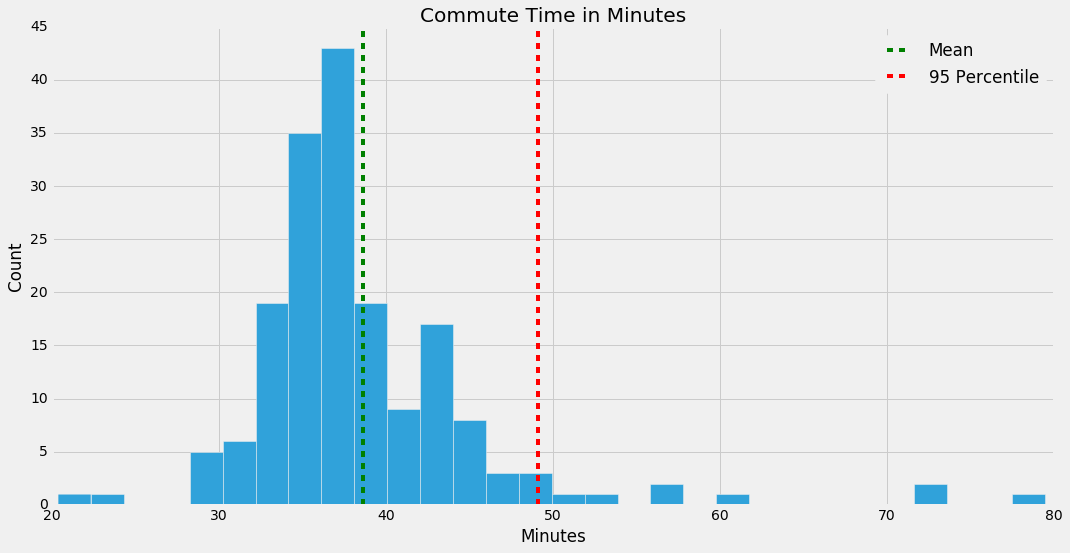

In [90]:
figure, ax = plt.subplots(figsize=(16, 8))

(commute_times['timediff'].dt.total_seconds() / 60).hist(ax=ax, bins=30)

ax.plot(
    [commute_times['timediff'].mean().total_seconds()/60 for i in range(2)],
    ax.get_ylim(), 'g--', label='Mean'
)

ax.plot(
    [commute_times['timediff'].quantile(.95).total_seconds()/60 for i in range(2)],
    ax.get_ylim(), 'r--', label='95 Percentile'
)

ax.set_title('Commute Time in Minutes')
ax.set_xlabel('Minutes')
ax.set_ylabel('Count')
ax.legend()

#commute_times

In [91]:
# Import the statsmodels API
import statsmodels.api as sm

# Import the statsmodels formula API
import statsmodels.formula.api as smf

In [104]:
commute_times['departure_time'].dt.second

247056     5
248597     7
246823    43
246685    34
247314     1
247989    49
246483    14
222023     5
247077    19
247059    28
246774    20
246448    17
247091     6
279014    25
275925    47
246394     0
246428     9
246480     0
246760    49
221288    39
297538    29
246457    37
246478     6
246730     9
246468    20
246669    48
246461    45
247164    15
247172    58
297993    38
          ..
292727     0
246817    43
247862    57
290400    20
275650     9
222231    12
212145    10
283550    29
265168    24
201437    28
290433    52
232874    15
247276    25
246430    42
246802     1
247243    44
266695    23
200134     8
222233    46
223914    31
264546    29
247914    12
291420    41
298685    26
214521    58
292799    52
293009    45
200137    49
292806    57
246703    20
Name: departure_time, dtype: int64

In [103]:
commute_times['departure_time'].dt.hour*3600 + commute_times['departure_time'].dt.minute*60 + commute_times['departure_time'].dt.second

247056    28085
248597    28087
246823    28363
246685    28294
247314    28441
247989    30049
246483    29954
222023    29885
247077    30199
247059    30028
246774    29960
246448    29837
247091    29886
279014    29665
275925    29927
246394    29820
246428    26349
246480    31800
246760    29809
221288    29919
297538    29849
246457    29797
246478    29826
246730    29769
246468    29660
246669    29868
246461    29805
247164    29355
247172    29758
297993    29798
          ...  
292727    31440
246817    30523
247862    30597
290400    30560
275650    30729
222231    31152
212145    30250
283550    30869
265168    31224
201437    30508
290433    30652
232874    30195
247276    30205
246430    30462
246802    30481
247243    30704
266695    30743
200134    29888
222233    29926
223914    29731
264546    30329
247914    29772
291420    30521
298685    29546
214521    30778
292799    30052
293009    27225
200137    30349
292806    29877
246703    30080
Name: departure_time, dt

In [111]:
# Run regression.  Note the call to `fit()` after the call to `ols`.
mod = smf.ols(formula='timediff ~ C(weekday)', data = {
    'timediff': commute_times['timediff'].dt.total_seconds(),
    'weekday': commute_times['timestamp'].dt.month
}).fit()

# Print the regression results
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:               timediff   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     1.802
Date:                Wed, 16 Aug 2017   Prob (F-statistic):             0.0572
Time:                        20:08:45   Log-Likelihood:                -1314.2
No. Observations:                 177   AIC:                             2652.
Df Residuals:                     165   BIC:                             2691.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept         2116.7242     99.084  

In [110]:
commute_times['timestamp'].dt.month

247056     9
248597     9
246823     9
246685     9
247314     9
247989     9
246483     9
222023     9
247077     9
247059     9
246774     9
246448     9
247091     9
279014     9
275925    10
246394    10
246428    10
246480    10
246760    10
221288    10
297538    10
246457    10
246478    10
246730    10
246468    10
246669    10
246461    10
247164    10
247172    10
297993    10
          ..
292727     6
246817     6
247862     6
290400     6
275650     6
222231     6
212145     6
283550     6
265168     6
201437     6
290433     6
232874     6
247276     6
246430     6
246802     7
247243     7
266695     7
200134     7
222233     7
223914     7
264546     7
247914     7
291420     7
298685     7
214521     7
292799     7
293009     7
200137     7
292806     8
246703     8
Name: timestamp, dtype: int64